# Orszag-Tang vortex

A classical test case for the magneto-hydro-dynamic. 

The equations are
\begin{align}
&\partial_t \rho + \partial_x \cdot q = 0,\\
&\partial_t q  + \partial_x \cdot \bigl( \rho u{\otimes}u + p^\star \mathbb{I} -B{\otimes}B \bigr) = 0,\\
&\partial_t E   + \partial_x \cdot \bigl( (E+p^\star)u - (u \cdot B) B \bigr) = 0,\\
&\partial_t B   + \partial_x \cdot \bigl(u{\otimes}B - B {\otimes} u \bigr) = 0,
\end{align}
with
\begin{align}
q &= \rho u,\\
p^\star &= p + \tfrac{1}{2} B\cdot B,\\
p &= (\gamma-1) (E - \tfrac{1}{2}\rho u\cdot u - \tfrac{1}{2}B\cdot B).
\end{align}

Periodical conditions on $[0,2\pi]^2$ are used. The initial conditions are
\begin{align}
\rho(x, y) &= \gamma^2,\\
q_x(x, y)  &= -\gamma^2 \sin(y), \\
q_y(x, y)  &=  \gamma^2 \sin(x), \\
p(x, y)    &= \gamma,\\
B_x(x, y)  &= -\sin(y),\\
B_y(x, y)  &= \sin(2x).
\end{align}

In [1]:
import numpy as np
import sympy as sp
import pyLBM

%matplotlib notebook

In [2]:
GA, X, Y, LA = sp.symbols('GA, X, Y, LA')
rho, qx, qy, E, Bx, By = sp.symbols('rho, qx, qy, E, Bx, By')
p, ps = sp.symbols('p, ps')
gamma = 5./3.

def init_rho(x, y):
    return gamma**2 * np.ones(x.shape)

def init_qx(x, y):
    return -gamma**2 * np.sin(y)

def init_qy(x, y):
    return gamma**2 * np.sin(x)

def init_Bx(x, y):
    return -np.sin(y)

def init_By(x, y):
    return np.sin(2*x)

def init_E(x, y):
    Ec = 0.5 * (init_qx(x, y)**2 + init_qy(x, y)**2)/init_rho(x, y)
    EB = 0.5 * (init_Bx(x, y)**2 + init_By(x, y)**2)
    return Ec + EB + gamma/(gamma-1)

In [3]:
# parameters
xmin, xmax, ymin, ymax = 0., 2*np.pi, 0., 2*np.pi
dx = np.pi / 128
s0, s1, s2, s3 = [1.95]*4
la = 10.

In [4]:
s_rho = [0., s1, s1, s0]
s_q = [0., s2, s2, s0]
s_E = [0., s3, s3, s0]
s_B = [0., s3, s3, s0]

p = (GA-1) * (E - (qx**2+qy**2)/(2*rho) - (Bx**2+By**2)/2)
ps = p + (Bx**2+By**2)/2
vB = (qx*Bx + qy*By)/rho

dico = {
    'box': {
        'x': [xmin, xmax], 
        'y': [ymin, ymax], 
        'label': -1,
    },
    'space_step': dx,
    'scheme_velocity': la,
    'schemes': [
        {
            'velocities': list(range(1,5)),
            'conserved_moments': rho,
            'polynomials': [1, LA*X, LA*Y, X**2-Y**2],
            'relaxation_parameters': s_rho,
            'equilibrium': [rho, qx, qy, 0.],
            'init': {rho: (init_rho,)},
        },
        {
            'velocities': list(range(1,5)),
            'conserved_moments': qx,
            'polynomials': [1, LA*X, LA*Y, X**2-Y**2],
            'relaxation_parameters': s_q,
            'equilibrium': [
                qx,
                qx**2/rho + ps - Bx**2,
                qx*qy/rho - Bx*By,
                0.
            ],
            'init': {qx: (init_qx,)},
        },
        {
            'velocities': list(range(1,5)),
            'conserved_moments': qy,
            'polynomials': [1, LA*X, LA*Y, X**2-Y**2],
            'relaxation_parameters': s_q,
            'equilibrium': [
                qy,
                qx*qy/rho - Bx*By,
                qy**2/rho + ps - By**2,
                0.
            ],
            'init': {qy: (init_qy,)},
        },
        {
            'velocities': list(range(1,5)),
            'conserved_moments': E,
            'polynomials': [1, LA*X, LA*Y, X**2-Y**2],
            'relaxation_parameters': s_E,
            'equilibrium': [
                E,
                (E+ps)*qx/rho - vB*Bx,
                (E+ps)*qy/rho - vB*By,
                0.
            ],
            'init': {E: (init_E,)},
        },
        {
            'velocities': list(range(1,5)),
            'conserved_moments': Bx,
            'polynomials': [1, LA*X, LA*Y, X**2-Y**2],
            'relaxation_parameters': s_B,
            'equilibrium': [
                Bx,
                0,
                (qy*Bx - qx*By)/rho,
                0.
            ],
            'init': {Bx: (init_Bx,)},
        },
        {
            'velocities': list(range(1,5)),
            'conserved_moments': By,
            'polynomials': [1, LA*X, LA*Y, X**2-Y**2],
            'relaxation_parameters': s_B,
            'equilibrium': [
                By,
                (qx*By - qy*Bx)/rho,
                0,
                0.
            ],
            'init': {By: (init_By,)},
        },
    ],
    'parameters': {LA: la, GA: gamma},
    'generator': 'cython',
}

sol = pyLBM.Simulation(dico)

<IPython.core.display.Javascript object>


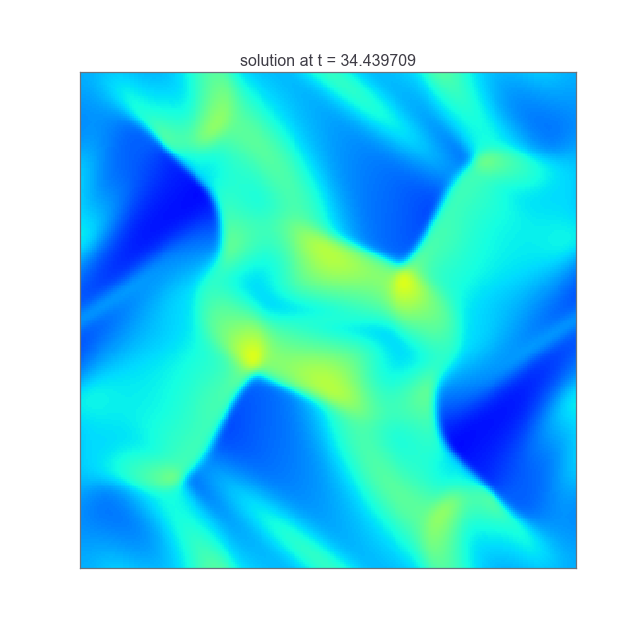

In [6]:
def update(iframe):
    for k in range(16):
        sol.one_time_step()      # increment the solution of one time step
    im.set_data(sol.m[rho].T)
    ax.title = 'solution at t = {0:f}'.format(sol.t)

# init viewer
viewer = pyLBM.viewer.matplotlibViewer
fig = viewer.Fig(figsize=(8,8))
ax = fig[0]
ax.grid(visible = False)
ax.xaxis_set_visible(False)
ax.yaxis_set_visible(False)
im = ax.image(sol.m[rho].T, cmap="jet", clim=[0.5, 7.2])
ax.title = 'solution at t = {0:f}'.format(sol.t)
# run the simulation
fig.animate(update, interval=1)
fig.show()